#### Build and install scikit-learn when using this notebook via ssh tunnel

(Selfnote: Restart notebook after running below)

In [ ]:
!source /cal/homes/vrajagopalan/.automations.sh; isk;

### Benchmark for RF w/Missing Value support

#### Sys stats

In [4]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
import platform;

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print "Running on %s" % platform.platform()
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
!echo -n "in branch \""
!echo -n "$(git --git-dir "$SCIKIT_LEARN_PATH"/.git rev-parse --abbrev-ref HEAD)\", "
!echo "($(git --git-dir "$SCIKIT_LEARN_PATH"/.git log --pretty=format:'%h-%s' -n 1))"
print "@ %s\n" % str(sklearn.__path__)
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.12.18-enst.1-x86_64-with-debian-7.11
At host "tsilinuxd98" with 8 cores. Current Dir - /tsi/doctorants/raghav/code/sklearn_dev_sandbox/tree_methods_missing_val_support

sklearn 0.18.dev0 in branch "missing_values_rf", (46b564e-[ci skip] tests)
@ ['/tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn']

np v1.12.0.dev0+59a7b25 - scipy v0.18.0.dev0+54c0d5a 
IPython v4.0.3 - Python 2.7.11 :: Anaconda 2.5.0 (64-bit)
@ /tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/bin/python


#### Imports

In [2]:
from timeit import default_timer as timer

%matplotlib inline

from get_graph import get_graph
from matplotlib import pyplot as plt
import numpy as np
import scipy
from math import sqrt

from sklearn.base import BaseEstimator

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer

from sklearn.datasets import *

from xgboost.sklearn import XGBClassifier

from xgbrf import XGBRFClassifier
from value_dropper import drop_values

#### The Setup

In [3]:
# Use all the cores
n_jobs = -1
n_estimators = 50
imputation_strategy = 'mean'
bootstrap = False
criterion = 'gini'
splitter = 'random'
missing_values = 'NaN'
random_state = 42
max_depth = 20

# To compute max_features, we need the shape of data before
# max_features = int(round(sqrt(data.shape[1])))
# max_feature_fraction = float(max_features) / data.shape[1]
max_feature_fraction = 0.8

# Use 3 iterations of SSS
cv = StratifiedShuffleSplit(n_iter=3, test_size=0.1,
                            random_state=42)


# THE ESTIMATORS

if splitter == "random":
    EnsembleClassifier = ExtraTreesClassifier
else:
    EnsembleClassifier = RandomForestClassifier

# 0. RF w/MV
rf_miss_val = EnsembleClassifier(n_estimators=n_estimators,
                                     criterion=criterion,
                                     max_features=max_feature_fraction,
                                     max_depth=max_depth,
                                     bootstrap=bootstrap,
                                     missing_values=missing_values,
                                     n_jobs=n_jobs,
                                     random_state=random_state)

# 1. Imputation ---> RF
rf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                      missing_values=missing_values)), 
                      ('rf', EnsembleClassifier(
                                 n_estimators=n_estimators,
                                 criterion=criterion,
                                 max_features=max_feature_fraction,
                                 max_depth=max_depth,
                                 bootstrap=bootstrap,
                                 # Don't allow missing, we've imputed them
                                 missing_values=None,  
                                 n_jobs=n_jobs,
                                 random_state=random_state))])

# 2. estimator to bench {Missing Data replaced with a MAX val + RF}
rf_max_min = EnsembleClassifier(
                 n_estimators=n_estimators,
                 criterion=criterion,
                 max_features=max_feature_fraction,
                 max_depth=max_depth,
                 bootstrap=True,
                 missing_values=None,
                 n_jobs=n_jobs,
                 random_state=42)

# 3. Imputation ---> DummyClassifier
dummy_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('dum', DummyClassifier())])

# 4. Imputation ---> LogisticRegressionCV
logit_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('log', LogisticRegressionCV(
                                     n_jobs=n_jobs,
                                     random_state=random_state))])

# 5. Imputation --> XGBoost's Gradient Boosting Clf
xgboost_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                           missing_values=missing_values)), 
                           ('xgb', XGBClassifier(
                                       # Don't allow missing, we've imputed them
                                       n_estimators=n_estimators,
                                       nthread=n_jobs,
                                       seed=random_state))])

# 6. XGBoost's Gradient Boosting Clf w/missing values handled inherently
xgboost_miss_val = XGBClassifier(n_estimators=n_estimators,
                                 missing=np.nan,  # XGBoost doesn't accept "NaN"
                                 nthread=n_jobs,
                                 seed=random_state)

# 7. Imputation --> XGBoost's RF (using num_parallel_tree)
xgbrf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('xgb', XGBRFClassifier(
                                     n_estimators=n_estimators,
                                     # Fraction of features to take for each tree
                                     # Take sqrt(n_features) / n_features
                                     colsample_bytree=max_feature_fraction,
                                     max_depth=max_depth,
                                     # No Bootstrapping, choose all samples exactly once
                                     num_boost_round=1,
                                     subsample=1,  
                                     nthread=n_jobs,
                                     seed=random_state))])

# 8. XGBoost's RF (using num_parallel_tree) w/missing values handled inherently
xgbrf_miss_val = XGBRFClassifier(
                       n_estimators=n_estimators,
                       # Fraction of features to take for each tree
                       # Take sqrt(n_features) / n_features
                       colsample_bytree=max_feature_fraction,
                       max_depth=max_depth,
                       # No Bootstrapping, choose all samples exactly once
                       missing=np.nan,
                       num_boost_round=1,
                       subsample=1,
                       nthread=n_jobs,
                       seed=random_state)

# 9. RF w/MV w/bootstrap
rf_miss_val_btstrp = EnsembleClassifier(n_estimators=n_estimators,
                                            bootstrap=True,
                                            criterion=criterion,
                                            missing_values=missing_values,
                                            max_features=max_feature_fraction,
                                            max_depth=max_depth,
                                            n_jobs=n_jobs,
                                            random_state=random_state)

# 10. IMP + RF w/o MV w/bootstrap
rf_impute_btstrp = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                             missing_values=missing_values)), 
                             ('rf', EnsembleClassifier(
                                        n_estimators=n_estimators,
                                        bootstrap=True,
                                        criterion=criterion,
                                        max_features=max_feature_fraction,
                                        max_depth=max_depth,
                                        # Don't allow missing, we've imputed them
                                        missing_values=None,  
                                        n_jobs=n_jobs,
                                        random_state=random_state))])

# 11. IMP + RF w/o MV w/bootstrap

rf_impute_btstrp = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                             missing_values=missing_values)), 
                             ('rf', EnsembleClassifier(
                                        n_estimators=n_estimators,
                                        bootstrap=True,
                                        criterion=criterion,
                                        max_features=max_feature_fraction,
                                        max_depth=max_depth,
                                        # Don't allow missing, we've imputed them
                                        missing_values=None,  
                                        n_jobs=n_jobs,
                                        random_state=random_state))])

#### The dataset

0.00 % of values missing
The shape of the entire dataset - (581012, 54); Target - (581012,)
The shape of the subsampled dataset - (14526, 54)

The maximum data value : 50098084.00 and minimum value : 23716.00

Labels -	[1 2 3 4 5 6 7]
Label counts -	[5285 7108  873   64  236  439  521]

For MNAR case, the labels to correlate are - [1]

The histogram of the label counts


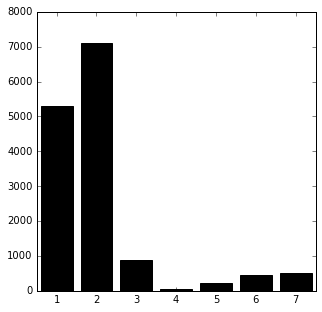

In [4]:
all_dataset_names = ["covtype", "iris", "make_classification"]

dataset_name = all_dataset_names[0]

if dataset_name == "covtype":
    dataset = fetch_covtype()
    data, target = dataset.data, dataset.target
    subsample_dataset = True
    make_binary = False
    subsample_interval = 40

elif dataset_name == "iris":
    dataset = load_iris()
    data, target = dataset.data, dataset.target
    subsample_dataset = False
    make_binary = False

elif dataset_name == "make_classification":
    data, target = make_classification(n_samples=10000, n_features=8,
                                       n_informative=6, n_redundant=2,
                                       n_classes=8,
                                       n_clusters_per_class=2,
                                       random_state=42)
    subsample_dataset = False
    make_binary = False

# densify
if scipy.sparse.issparse(data):
    print "Data is sparse! Attempting densification"
    data = data.toarray()

# Initially we have no missing
print "%0.2f %% of values missing" % (np.mean(np.isnan(target))*100)

print "The shape of the entire dataset - %s; Target - %s" % (str(data.shape), str(target.shape))
if subsample_dataset:
    #Subsample the data
    data, target = data[::subsample_interval], target[::subsample_interval]
    print "The shape of the subsampled dataset - %s" % str(data.shape)
    print

if make_binary:
    mask = target <= 2
    data, target = data[mask], target[mask]
    print "The shape of the binary dataset - %s" % str(data.shape)
    print

# Set the data_max and data_min vars
data_max = data.max() ** 2
data_min = data.min() ** 2


print "The maximum data value : %0.2f and minimum value : %0.2f" % (data_max, data_min)
print

labels = np.unique(target)
print "Labels -\t", labels
label_counts = np.bincount(target)[-len(labels):]
print "Label counts -\t", label_counts
print

labels_to_correlate_for_mnar = [1]

print "For MNAR case, the labels to correlate are - %s" % labels_to_correlate_for_mnar
print

print "The histogram of the label counts"

old_fig_size = plt.rcParams['figure.figsize'][:]
plt.rcParams['figure.figsize'][:] = [5, 5]
plt.bar(labels+0, label_counts, color='k', align='center')
plt.xlim([np.min(labels)-0.5, np.max(labels)+0.5])
plt.rcParams['figure.figsize'][:] = old_fig_size
plt.show()

#### Selectively Benchmark

In [5]:
# For the plot legend
est_labels = [
    'XTreesClf w/MV w/o bstrp',                                # 0
    'IMP + XTreesClf w/o bstrp',                               # 1
    'Missing max replaced + RF',              # 2
    'IMP + Dummy',                            # 3
    'IMP + Logit',                            # 4
    'XGB w/MV handled internally',            # 5
    'IMP + XGB',                              # 6
    'XGBs RF w/MV handled internally',        # 7
    'IMP + XGBs RF',                          # 8
    'XTreesClf w/bstrp w/MV',            # 9
    'IMP + XTreesClf w/bstrp',           # 10
]  

# The estimators/techniques to run for benchmarking
bench_mask = [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#    7,
#    8,
    9,
    10,
]

# The estimators/techniques for the score plots
score_plot_mask =  [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#    7,
#    8,
    9,
    10,
]

# The estimators/techniques for the time plots
time_plot_mask =  [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#    7,
#    8,
    9,
    10,
]

n_experiments_per_plot = 30
min_label_correlation, max_label_correlation = 0., 1  # 1 is fully MNAR, which is not possible 0.9 is noisy MNAR
                                                       # plus 1 performs almost as good as our impl, while
                                                       # a label correlation of 0.9 does not
n_correlation_levels = 11

#### Some baseline scores

In [6]:
#print ('The baseline score without missing (RF) is %0.8f'
#       % cross_val_score(rf_miss_val, data, target, cv=cv).mean())

In [7]:
#print ('The baseline score without missing (xgboost) is %0.8f'
#       % cross_val_score(xgboost_miss_val, data, target, cv=cv).mean())

In [8]:
#print ('The baseline score without missing (xgboost) is %0.8f'
#       % cross_val_score(xgbrf_miss_val, data, target, cv=cv).mean())

#### The Benchmark

In [9]:
print 'The bench mask is %s' % bench_mask

missing_mask = np.zeros(data.shape, dtype=bool)
labels = None

label_1_fraction = np.mean(target==labels_to_correlate_for_mnar[0])
print label_1_fraction

label_correlations = np.linspace(min_label_correlation, max_label_correlation, n_correlation_levels)
print 'The label correlations %s ' % label_correlations
missing_fractions = list([(np.linspace(0, 0.80, n_experiments_per_plot) if label_correlation_i == 0
                           # Label 1 accounts of only around 35% of the samples
                           else np.linspace(0, 0.9 * label_1_fraction, n_experiments_per_plot))
                          for label_correlation_i in label_correlations])

rng = np.random.RandomState(random_state)
                        
n_samples, n_features = data.shape
n_missing_fractions = list(map(len, missing_fractions))

n_experiments = len(label_correlations) * sum(n_missing_fractions)

# Intialize the scores and times with zeros
rf_miss_val_scores = np.zeros(n_experiments)
rf_impute_scores = np.zeros(n_experiments)
rf_max_min_scores = np.zeros(n_experiments)
dummy_impute_scores = np.zeros(n_experiments)
logit_impute_scores = np.zeros(n_experiments)
xgboost_impute_scores = np.zeros(n_experiments)
xgboost_miss_val_scores = np.zeros(n_experiments)
xgbrf_miss_val_scores = np.zeros(n_experiments)
xgbrf_impute_scores = np.zeros(n_experiments)
rf_miss_val_btstrp_scores = np.zeros(n_experiments)
rf_impute_btstrp_scores = np.zeros(n_experiments)

rf_miss_val_times = np.zeros(n_experiments)
rf_impute_times = np.zeros(n_experiments)
rf_max_min_times = np.zeros(n_experiments)
dummy_impute_times = np.zeros(n_experiments)
logit_impute_times = np.zeros(n_experiments)
xgboost_impute_times = np.zeros(n_experiments)
xgboost_miss_val_times = np.zeros(n_experiments)
xgbrf_miss_val_times = np.zeros(n_experiments)
xgbrf_impute_times = np.zeros(n_experiments)
rf_miss_val_btstrp_times = np.zeros(n_experiments)
rf_impute_btstrp_times = np.zeros(n_experiments)

experiment_i = -1
for i, label_correlation in enumerate(label_correlations):
    labels = labels_to_correlate_for_mnar
    print "Labels correlated with - %s" % str(labels)
    print "Label correlation - %0.2f" % label_correlation
    print
    
    X, y = data.copy(), target.copy()
    missing_mask = np.zeros(X.shape, dtype=bool)
        
    for j, missing_fraction in enumerate(missing_fractions[i]):
        print
        print "-------------------------------------------------------"
        
        """
        # Old way of generating missing data --------------------------
        rv = rng.randn(*X.shape)
        rv = rng.randn(*X.shape)
        thresh = np.sort(rv.ravel())[int(missing_fraction * n_samples * n_features)]
        missing_mask += rv < thresh
        if label_correlation == 1:  # MNAR
            missing_mask[y!=labels[0]] = False  # Features should go missing only for y=1
        X[missing_mask] = np.nan
        # -------------------------------------------------------------
        """
        
        # Generate the missing values using the `drop_values` function
        X, y, missing_mask, label = drop_values(
            X, y,
            missing_mask=missing_mask,
            missing_fraction=missing_fraction,
            # The MCAR-ness should not change
            label_correlation=label_correlation,
            # Persist the correlation with the same label
            labels=labels,
            return_missing_mask=True,
            return_labels=True,
            random_state=random_state,
            )
        
        print ("Missing fraction - (Expected - %0.4f, Actual - %0.4f)"
               % (missing_fraction, missing_mask.mean()))
        print ("Fraction of samples missing when label == %d - %0.4f"
               % (labels[0], missing_mask[y==labels[0]].mean()))
        print ("Fraction of samples missing when label != %d - %0.4f"
               % (labels[0], missing_mask[y!=labels[0]].mean()))
        print "-------------------------------------------------------"
        
        experiment_i += 1
        
        # RF w/MV
        if 0 in bench_mask:
            start = timer()
            rf_miss_val_scores[experiment_i] = (
                cross_val_score(rf_miss_val, X, y, cv=cv).mean())
            rf_miss_val_times[experiment_i] = timer() - start
            print ("RF w/MV completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_times[experiment_i],
                      rf_miss_val_scores[experiment_i]))
        
        # IMP + RF
        if 1 in bench_mask:
            start = timer()
            rf_impute_scores[experiment_i] = (
                cross_val_score(rf_impute, X, y, cv=cv).mean())
            rf_impute_times[experiment_i] = timer() - start
            print ("IMP + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_times[experiment_i],
                      rf_impute_scores[experiment_i]))
            print
        
        # X replaced + RF
        if 2 in bench_mask:
            # Replace X's nan with data_max/data_min
            X[missing_mask] = data_max
            start = timer()
            rf_max_min_scores[experiment_i] = (
                cross_val_score(rf_max_min, X, y, cv=cv).mean())
            rf_max_min_times[experiment_i] = timer() - start
            # Revert the change
            X[missing_mask] = np.nan
            print ("Missing replaced + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_max_min_times[experiment_i],
                      rf_max_min_scores[experiment_i]))
        
        # IMP + Dummy
        if 3 in bench_mask:
            start = timer()
            dummy_impute_scores[experiment_i] = (
                cross_val_score(dummy_impute, X, y, cv=cv).mean())
            dummy_impute_times = timer() - start
            print ("IMP + Dummy completed in %0.2f s with a mean score of %0.4f"
                   % (dummy_impute_times[experiment_i],
                      dummy_impute_scores[experiment_i]))
            print


        # IMP + Logistic Regression
        if 4 in bench_mask:
            start = timer()
            logit_impute_scores[experiment_i] = (
                cross_val_score(logit_impute, X, y, cv=cv).mean())
            logit_impute_times[experiment_i] = timer() - start
            print ("IMP + Logit completed in %0.2f s with a mean score of %0.4f"
                   % (logit_impute_times[experiment_i],
                      logit_impute_scores[experiment_i]))
            print

        # XGB's GB w/MV
        if 5 in bench_mask:
            start = timer()
            xgboost_miss_val_scores[experiment_i] = (
                cross_val_score(xgboost_miss_val, X, y, cv=cv).mean())
            xgboost_miss_val_times = timer() - start
            print ("XGBoost w/miss val handled internally completed in %0.2f s "
                   "with a mean score of %0.4f"
                   % (xgboost_miss_val_times[-1], xgboost_miss_val_scores[-1]))        
        
        # Imp + XGB's GB
        if 6 in bench_mask:
            start = timer()
            xgboost_impute_scores[experiment_i] = (
                cross_val_score(xgboost_impute, X, y, cv=cv).mean())
            xgboost_impute_times = timer() - start
            print ("Imp + XGBoost GB completed in %0.2f s"
                   "with a mean score of %0.4f"
                   % (xgboost_impute_times[experiment_i],
                      xgboost_impute_scores[experiment_i]))        
            print
                                     
        # XGB's RF w/MV
        if 7 in bench_mask:
            start = timer()
            xgbrf_miss_val_scores[experiment_i] = (
                cross_val_score(xgbrf_miss_val, X, y, cv=cv).mean())
            xgbrf_miss_val_times[experiment_i] = timer() - start
            print ("XGBoosts RF  w/miss val handled internally completed"
                   " in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_miss_val_times[experiment_i],
                      xgbrf_miss_val_scores[experiment_i]))

        # Imp + XGB's RF
        if 8 in bench_mask:
            start = timer()
            xgbrf_impute_scores[experiment_i] = (
                cross_val_score(xgbrf_impute, X, y, cv=cv).mean())
            xgbrf_impute_times[experiment_i] = timer() - start
            print ("Imp + XGBoosts RF completed in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_impute_times[experiment_i],
                      xgbrf_impute_scores[experiment_i]))
            print
            
        # RF w/MV and bootstrap set to True
        if 9 in bench_mask:
            start = timer()
            rf_miss_val_btstrp_scores[experiment_i] = (
                cross_val_score(rf_miss_val_btstrp, X, y, cv=cv).mean())
            rf_miss_val_btstrp_times[experiment_i] = timer() - start
            print ("RF w/MV w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_btstrp_times[experiment_i],
                      rf_miss_val_btstrp_scores[experiment_i]))
        
        # IMP + RF w boostrap set to True
        if 10 in bench_mask:
            start = timer()
            rf_impute_btstrp_scores[experiment_i] = (
                cross_val_score(rf_impute_btstrp, X, y, cv=cv).mean())
            rf_impute_btstrp_times[experiment_i] = timer() - start
            print ("IMP + RF w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_btstrp_times[experiment_i],
                      rf_impute_btstrp_scores[experiment_i]))

        print "-------------------------------------------------------"

The bench mask is [9, 10]
0.363830373124
The label correlations [ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1. ] 
Labels correlated with - [1]
Label correlation - 0.00


-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/0
Missing fraction - (Expected - 0.0000, Actual - 0.0000)
Fraction of samples missing when label == 1 - 0.0000
Fraction of samples missing when label != 1 - 0.0000
-------------------------------------------------------
RF w/MV w/bootstrap completed in 1.95 s with a mean score of 0.8197
IMP + RF w/bootstrap completed in 1.94 s with a mean score of 0.8197
-------------------------------------------------------

-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/21638
Missing fraction - (Expected - 0.0276, Actual - 0.0276)
Fraction of samples missing when label == 1 - 0.0277
Fraction of samples missing when label != 1 - 0.0275
----

#### Plotting the results

Labels correlated with - [1]
Label correlation - 0.00

Plotting the benchmark scores and times when label_correlation is 0.00. n_estimators=50
dataset - covtype. data shape - (14526, 54).


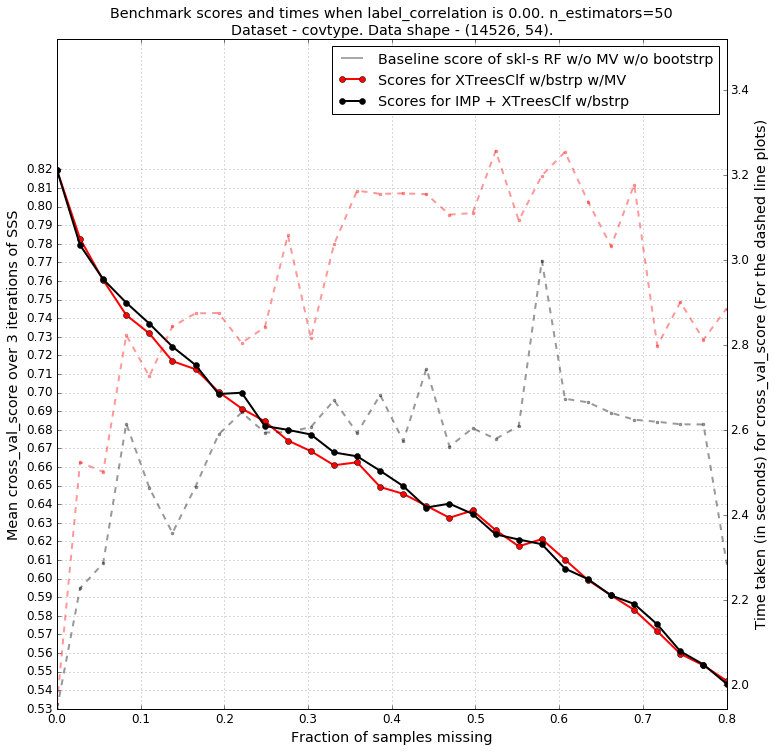

Label correlation - 0.10

Plotting the benchmark scores and times when label_correlation is 0.10. n_estimators=50
dataset - covtype. data shape - (14526, 54).


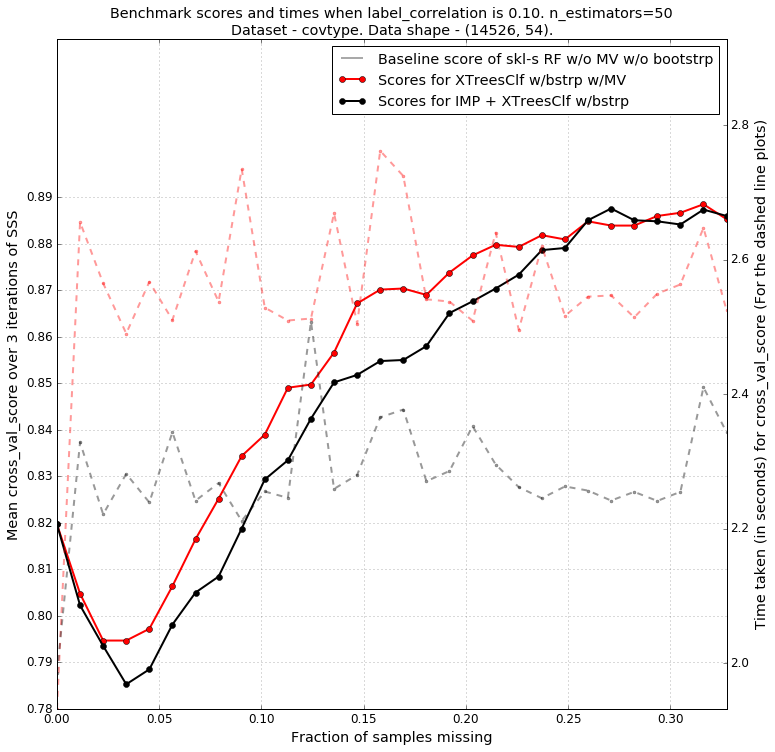

Label correlation - 0.20

Plotting the benchmark scores and times when label_correlation is 0.20. n_estimators=50
dataset - covtype. data shape - (14526, 54).


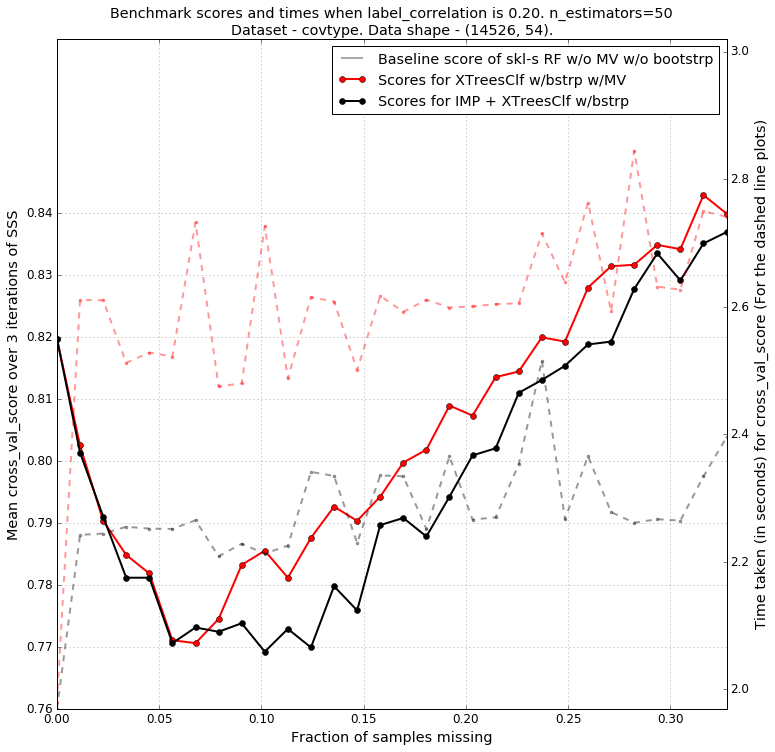

Label correlation - 0.30

Plotting the benchmark scores and times when label_correlation is 0.30. n_estimators=50
dataset - covtype. data shape - (14526, 54).


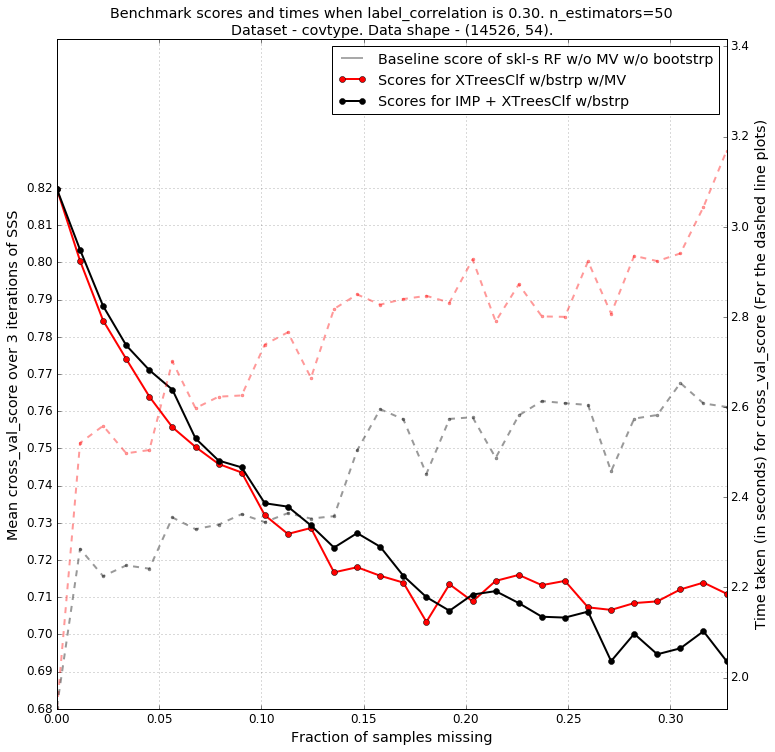

Label correlation - 0.40

Plotting the benchmark scores and times when label_correlation is 0.40. n_estimators=50
dataset - covtype. data shape - (14526, 54).


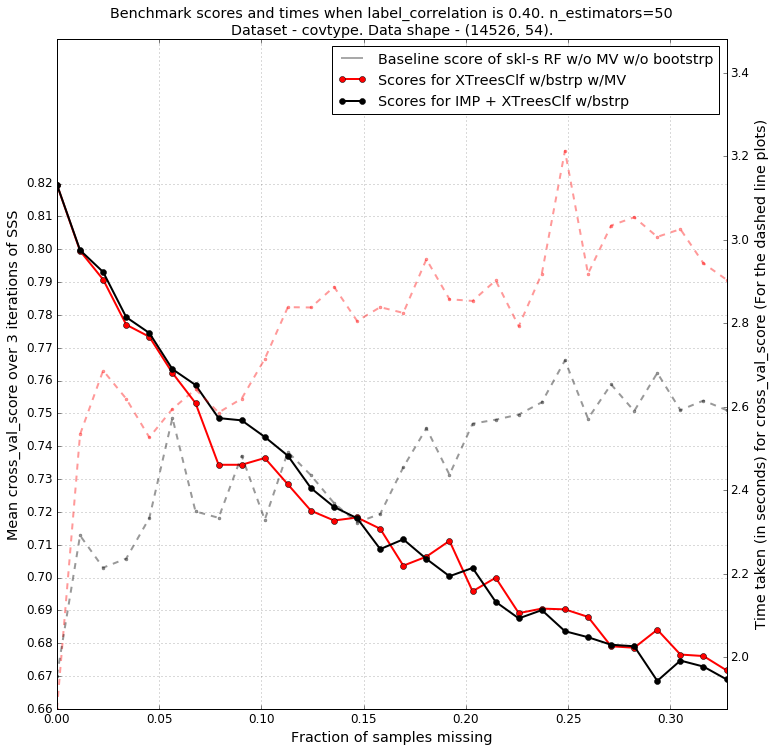

Label correlation - 0.50

Plotting the benchmark scores and times when label_correlation is 0.50. n_estimators=50
dataset - covtype. data shape - (14526, 54).


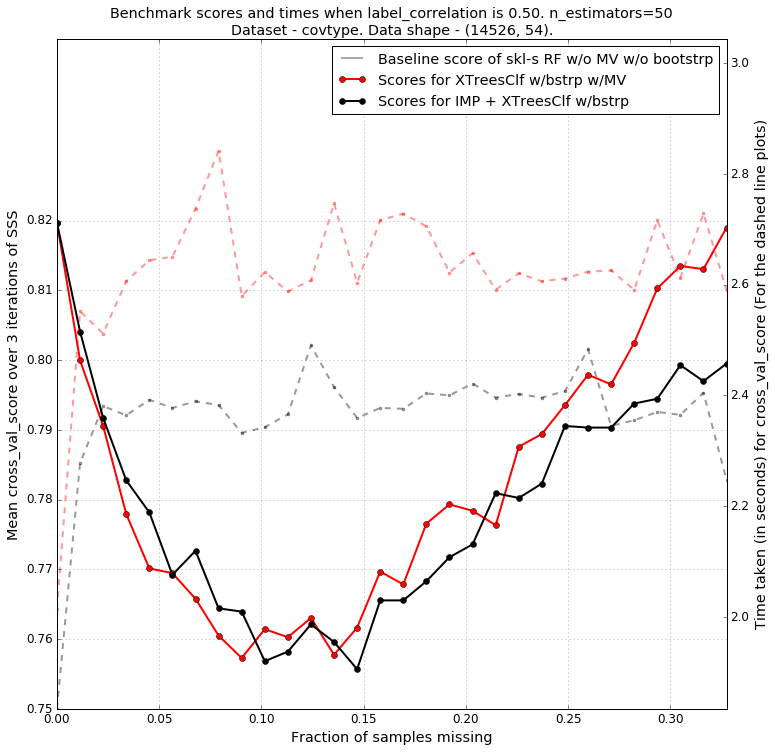

Label correlation - 0.60

Plotting the benchmark scores and times when label_correlation is 0.60. n_estimators=50
dataset - covtype. data shape - (14526, 54).


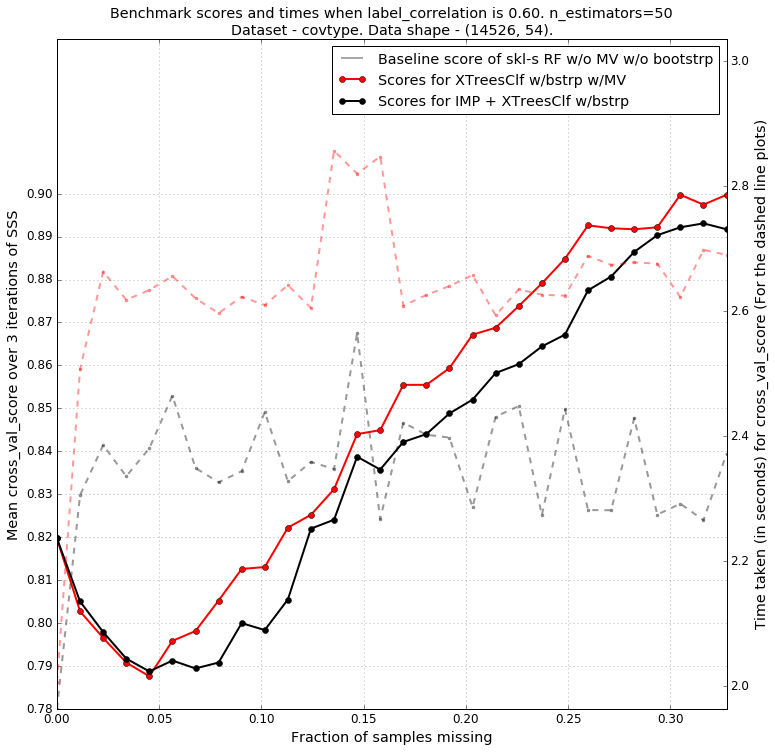

Label correlation - 0.70

Plotting the benchmark scores and times when label_correlation is 0.70. n_estimators=50
dataset - covtype. data shape - (14526, 54).


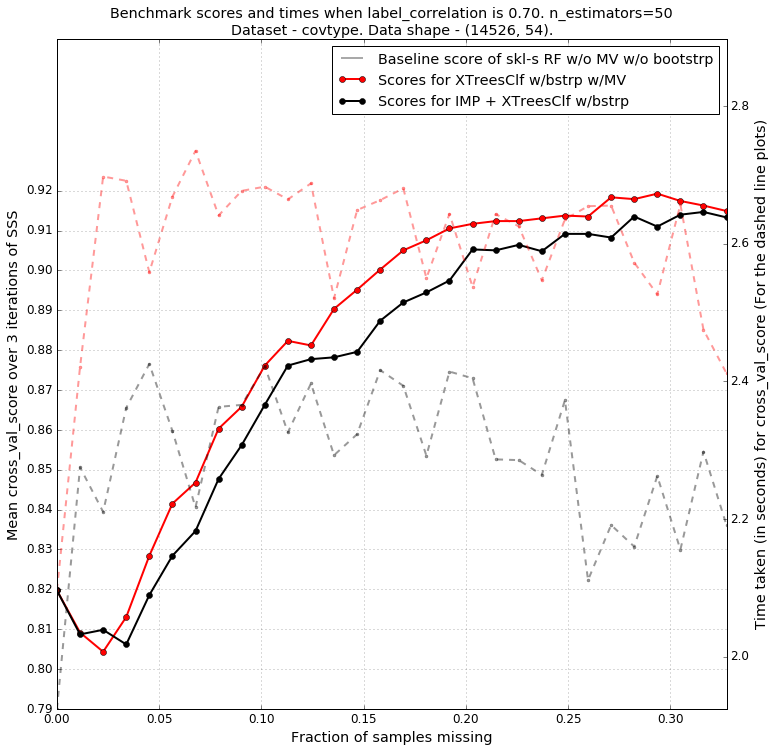

Label correlation - 0.80

Plotting the benchmark scores and times when label_correlation is 0.80. n_estimators=50
dataset - covtype. data shape - (14526, 54).


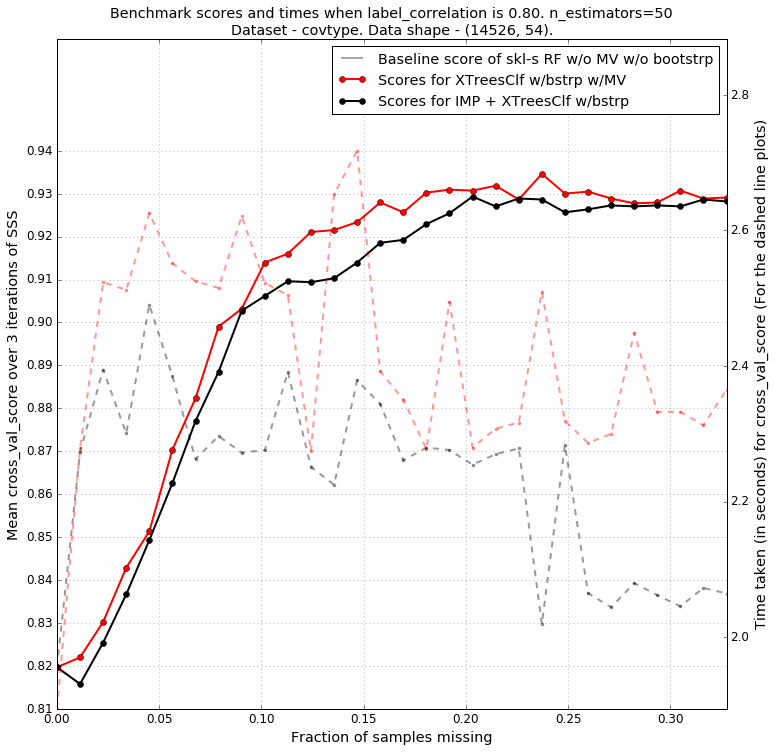

Label correlation - 0.90

Plotting the benchmark scores and times when label_correlation is 0.90. n_estimators=50
dataset - covtype. data shape - (14526, 54).


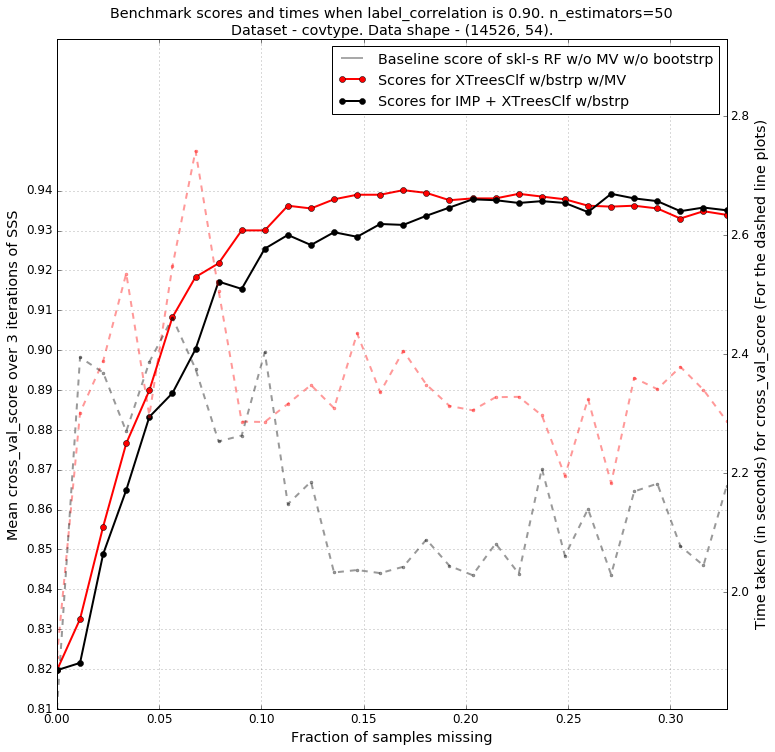

Label correlation - 1.00

Plotting the benchmark scores and times when label_correlation is 1.00. n_estimators=50
dataset - covtype. data shape - (14526, 54).


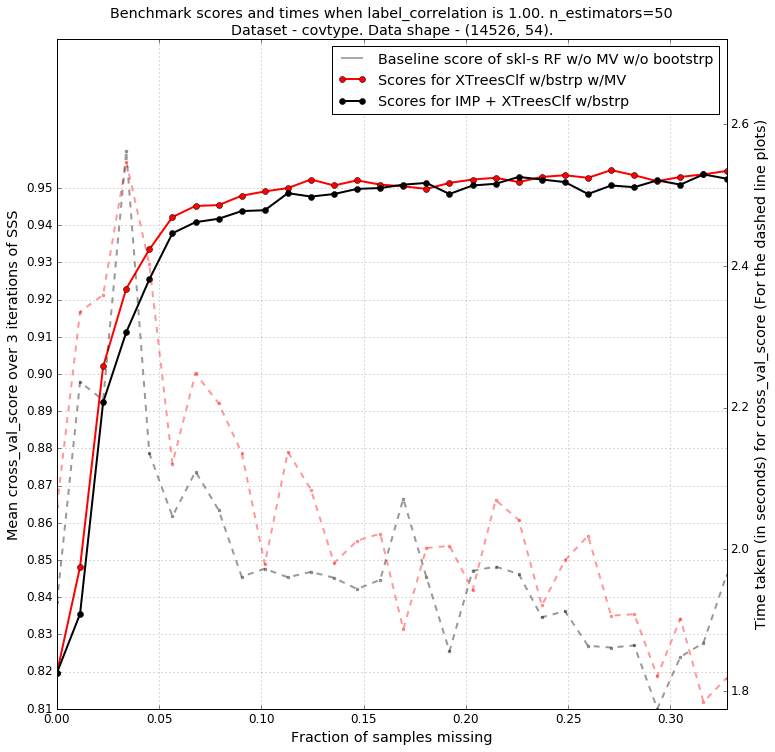

In [10]:
plt.rcParams['figure.figsize'][:] = [12, 12]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'

# Plot the scores and times
index = 0
if label_correlation != 0:
        print "Labels correlated with - %s" % str(labels)

# For the score plot
plot_colors = ['olive', 'lightpink', 'g', 'b', 'yellow', 'brown', 'm',
               'cyan', 'lime', 'r', 'k']

for idx, label_correlation in enumerate(label_correlations):
    print "Label correlation - %0.2f" % label_correlation
    print
    
    title = ("Benchmark scores and times when label_correlation is %0.2f. n_estimators=%d"
             % (label_correlation, n_estimators))
    title += "\nDataset - %s. Data shape - %s." % (dataset_name, str(data.shape))
    print "Plotting the", title.lower()
    
    current_slice = range(index, index + n_missing_fractions[idx])
    index += n_missing_fractions[idx]
    
    all_scores = np.array([
        rf_miss_val_scores[current_slice],
        rf_impute_scores[current_slice],
        rf_max_min_scores[current_slice],
        dummy_impute_scores[current_slice],
        logit_impute_scores[current_slice],
        xgboost_miss_val_scores[current_slice],
        xgboost_impute_scores[current_slice],
        xgbrf_miss_val_scores[current_slice],
        xgbrf_impute_scores[current_slice],
        rf_miss_val_btstrp_scores[current_slice],
        rf_impute_btstrp_scores[current_slice],
        ])

    all_times = np.array([
        rf_miss_val_times[current_slice],
        rf_impute_times[current_slice],
        rf_max_min_times[current_slice],
        dummy_impute_times[current_slice],
        logit_impute_times[current_slice],
        xgboost_miss_val_times[current_slice],
        xgboost_impute_times[current_slice],
        xgbrf_miss_val_times[current_slice],
        xgbrf_impute_times[current_slice],
        rf_miss_val_btstrp_times[current_slice],
        rf_impute_btstrp_times[current_slice],
    ])
    
    #print missing_fractions[idx]
    #print current_slice
    fig, ax1 = plt.subplots()
    # Get the right y axis for time plot
    ax2 = ax1.twinx()

    # A straight line for the baseline score
    # The first score is computed with no missing values
    l1 = ax1.axhline(all_scores[0][0], label='Baseline score of skl-s RF w/o MV w/o bootstrp',
                     color='darkgrey', linewidth=2)
    
    for i, scores in enumerate(all_scores):
        # print i
        if i in score_plot_mask:
            l2 = ax1.plot(missing_fractions[idx], scores,
                          'o-',
                          color=plot_colors[i],
                          label="Scores for %s" % est_labels[i],
                          linewidth=2)

    for i, times in enumerate(all_times):
        # print i
        if i in time_plot_mask:
            l3 = ax2.plot(missing_fractions[idx], times,
                          '.--',
                          color=plot_colors[i],
                          linewidth=2,
                          alpha=0.4)    

    # Compute the axis extremes, to position the legend cleanly
    score_decimals = 2
    min_score = np.round(np.min(all_scores[score_plot_mask][all_scores[score_plot_mask]!=0]),
                         score_decimals) - 0.1**score_decimals
    max_score = np.round(np.max(all_scores[score_plot_mask]),
                         score_decimals) + 0.1**score_decimals
    
    score_space_for_legend = (max_score - min_score) / 5.
    
    min_time = np.min(all_times[time_plot_mask][all_times[time_plot_mask]!=0])
    max_time = np.max(all_times[time_plot_mask])
    
    time_space_for_legend = (max_time - min_time) / 5.
    
    ax1.set_xlim([missing_fractions[idx][0], missing_fractions[idx][-1]])
    ax1.set_ylim([min_score, max_score + score_space_for_legend])
    ax1.set_yticks(np.arange(min_score, max_score, 0.1**score_decimals))
    ax1.set_ylabel('Mean cross_val_score over 3 iterations of SSS')
    ax1.grid(True, alpha=0.6)
    
    ax2.set_ylabel('Time taken (in seconds) for cross_val_score (For the dashed line plots)')
    ax2.set_ylim([min_time, max_time + time_space_for_legend])
    
    ax1.legend(loc=1)
    # ax2.grid(True)
    # ax2.legend(loc='best')
    
    # plt.legend(loc='best')
    
    ax1.set_xlabel("Fraction of samples missing")    
    plt.title(title)    
    plt.show()

In [11]:
# X = np.array([[0, 2, 3],
#               [6, 8, 5],
#               [2, 3, 4],
#               [5, 6, 7],
#               [8, 8, 8],
#               [8, 8, 8],
#               [8, 8, 8],
#               [8, 8, 8],
#               [9, 8, 8],
#               [10, 0, 1]], dtype=np.float)

# y = np.array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2])

# mm = np.isnan(X)

# X, y, mm = drop_values(X, y, missing_mask=mm, missing_fraction=0.1,
#                        labels=[1], label_correlation=0.75,
#                        return_missing_mask=True,
#                        random_state=42)

# print X, mm.mean()

In [12]:
# missing_mask[y!=1].mean()

In [13]:
# drop_values(data, target, missing_fraction=0.0,
#             missing_mask=mm,
#             return_missing_mask=True)

In [14]:
# #rf_with_impute.fit(data, target)

# #rf_missing_val.estimators_[0]

# import matplotlib.pyplot as plt
# import pygraphviz as pgv
# import networkx as nx
# import pygraphviz
# import matplotlib.image as img
# import matplotlib.pyplot as plt

# from sklearn.tree import export_graphviz
# from StringIO import StringIO
# from io import BytesIO

# def get_graph(dtc, n_classes, feat_names=None, size=[7, 7], max_depth=10):
#     dot_file = StringIO()
#     image_file = BytesIO()

#     # Get the dot graph of our decision tree
#     export_graphviz(dtc, out_file=dot_file, feature_names=feat_names,
#                     rounded=True, filled=True,
#                     special_characters=True,
#                     class_names=map(str, range(1, n_classes+1)),
#                     max_depth=max_depth)
#     dot_file.seek(0)

#     # Convert this dot graph into an image
#     g = pygraphviz.AGraph(dot_file.read())
#     g.layout('dot')
#     # g.draw doesn't work when the image object doesn't have a name (with a proper extension)
#     image_file.name = "image.png"
#     image_file.seek(0)
#     g.draw(path=image_file)
#     image_file.seek(0)

#     # Plot it
#     plt.figure().set_size_inches(*size)
#     plt.axis('off')
#     plt.imshow(img.imread(fname=image_file))
#     plt.show()

In [15]:
# X[:, 0].size

In [16]:
# #dtc = rf_with_impute.steps[1][1].estimators_[0]
# #dtc2= rf_miss_val.estimators_[4]
# print np.isnan(X).mean(), missing_mask.mean()
# print X.shape

In [17]:
# dtc = DecisionTreeClassifier(random_state=0, missing_values='NaN')
# #dtc = rf_miss_val.fit(X, y).estimators_[1]
# dtc.fit(X, y)

In [18]:
# get_graph(dtc, n_classes=len(np.unique(y)),
#           feat_names=np.arange(X.shape[1]), size=[100, 200], max_depth=4)

In [19]:
# plt.close('all')
# plt.plot(missing_fraction_range, seconds_missing, '.--', color='r', label='RF MV enabled')
# plt.plot(missing_fraction_range, seconds_impute, '.--', color='b', label='RF+imputer')
# plt.axhline(35, label='RF w/No missing', color='k')
# #for sample_pt in missing_fraction_range:
# #    plt.axvline(sample_pt, linestyle='--', color='g')
# plt.xlabel('Missing fraction')
# plt.ylabel('Time taken for cross_val_score using 3 iterations of StratifiedShuffleSplit in seconds')
# plt.legend(loc='best')
# plt.show()

In [20]:
# from sklearn.datasets import fetch_mldata

# adult = fetch_mldata('yeast')

In [21]:
# cat_feats = np.load('cat_feats.npy').tolist()
# feat_names = np.load('feat_names.npy').tolist()
# data = np.load('data.npy')
# target = np.load('target.npy')

#### Debugging missing value support

(6, 2, 0)
(7.0, 6.0)
(3, 2, 1)
(3.0, 3.0)
(10, 0, 2)
(3.0, 4.0)
  (0, 0)	nan
  (1, 0)	nan
  (3, 0)	1.0
  (4, 0)	2.0
  (5, 0)	3.0
  (6, 0)	4.0
  (7, 0)	5.0
  (8, 0)	10.0
  (9, 0)	11.0
  (10, 0)	12.0
  (11, 0)	13.0
  (12, 0)	14.0
[1 1 1 1 2 2 2 2 3 3 3 3 3]
[1 1 3 1 2 2 2 2 3 3 3 3 3]


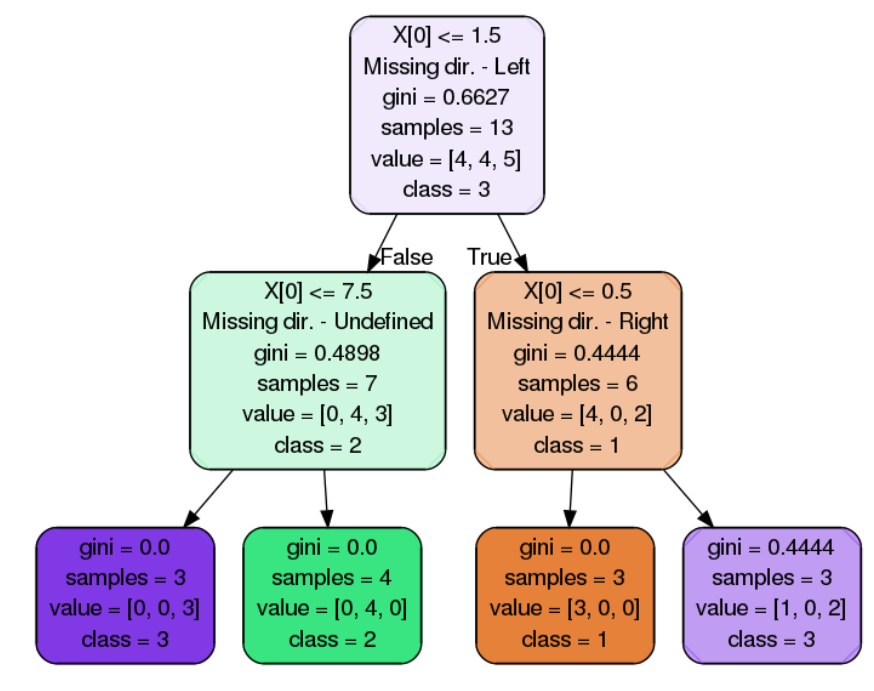

In [6]:
# Toy data which will send all the missing values to the right at the root node
%matplotlib inline

import numpy as np
from scipy.sparse import coo_matrix
from sklearn.tree import DecisionTreeClassifier
from get_graph import get_graph

X = np.array(
        [[np.nan],
         [np.nan],
         [0],
         [1],
         [2],
         [3],
         [4],
         [5],
         [10],
         [11],
         [12],
         [13],
         [14]])

X = coo_matrix(X)

y = np.array([1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3])
dtc = DecisionTreeClassifier(missing_values='NaN', splitter='best', random_state=4).fit(X, y)
print X
print y
print dtc.predict(X)
get_graph(dtc, size=(15, 15))

In [24]:
rng = np.random.RandomState(42)

X = np.array([[np.nan], [np.nan], [np.nan], [np.nan],
              [0], [1], [2], [3], [4], [5],
              [10], [11], [12], [13], [15]])
y = np.array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

dtc = DecisionTreeClassifier(missing_values="NaN",
                             splitter="random",
                             random_state=42).fit(X, y)

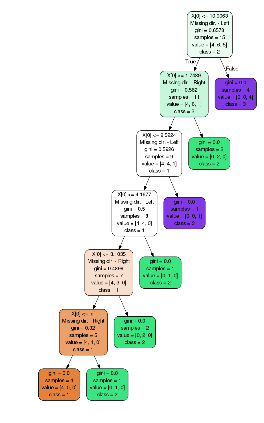

In [25]:
get_graph(dtc)

In [26]:
# # coding: utf-8
# # pylint: disable=too-many-arguments, too-many-locals, invalid-name, fixme
# """Scikit-Learn Wrapper interface for XGBoost."""
# from __future__ import absolute_import

# import numpy as np
# from xgboost.core import Booster, DMatrix, XGBoostError
# from xgboost.training import train

# from xgboost.compat import (SKLEARN_INSTALLED, XGBModelBase,
#                             XGBClassifierBase, XGBRegressorBase, LabelEncoder)



In [27]:
# xgbrf = XGBRFClassifier(n_estimators=n_estimators,
#                         nthread=n_jobs,
#                         max_depth=100,
#                         missing=np.nan,
#                         objective='multiclass:logistic',
#                         subsample=0.6,
#                         seed=random_state,
#                         base_score=0)

In [28]:
# cross_val_score(xgbrf, data, target, cv=cv, fit_params={'eval_metric': 'auc'})

In [6]:
import numpy as np
import pandas as pd

titanic = pd.read_csv(open('../../data/titanic_train.csv', 'rb'), delimiter=',')

In [54]:
titanic = titanic.drop(['Name', 'Ticket'], axis=1)

In [72]:
titanic.Fare = titanic.Fare.map(lambda x: np.nan if x == 0 else x)

In [75]:
titanic.Cabin.tolist()

[nan,
 'C85',
 nan,
 'C123',
 nan,
 nan,
 'E46',
 nan,
 nan,
 nan,
 'G6',
 'C103',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'D56',
 nan,
 'A6',
 nan,
 nan,
 nan,
 'C23 C25 C27',
 nan,
 nan,
 nan,
 'B78',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'D33',
 nan,
 'B30',
 'C52',
 nan,
 nan,
 nan,
 nan,
 nan,
 'B28',
 'C83',
 nan,
 nan,
 nan,
 'F33',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'F G73',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'C23 C25 C27',
 nan,
 nan,
 nan,
 'E31',
 nan,
 nan,
 nan,
 'A5',
 'D10 D12',
 nan,
 nan,
 nan,
 nan,
 'D26',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'C110',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'B58 B60',
 nan,
 nan,
 nan,
 nan,
 'E101',
 'D26',
 nan,
 nan,
 nan,
 'F E69',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'D47',
 'C123',
 nan,
 'B86',
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 'F2',
 nan,
 nan,
 'C2'

In [82]:
%%cython

cdef int a = 5



Error compiling Cython file:
------------------------------------------------------------
...

cdef int a = 5
a = 'aa'
   ^
------------------------------------------------------------

/cal/homes/vrajagopalan/.cache/ipython/cython/_cython_magic_699affda2f77d409cd825ce9f8704319.pyx:3:4: Only single-character string literals can be coerced into ints.


In [77]:
%load_ext cython

In [ ]:
class EmployeeTree:
    def __init__(self):
        self.root = None
        self.height = 0
        self.n_elements = 0
        # To quickly locate nodes
        self.hashmap = dict()
        
    def add_employee(eid, boss, sal, rating):
        if self.root is None:
            self.root = Employee(eid, sal, rating)
        else:
            # self.find(boss) should return a sorted linked list (pqueue?)
            self.find(boss).sorted_insert_employee(Employee(eid, sal, rating))
            
        self.height += 1
        self.n_elements += 1

In [3]:
[1, 2, 3, 4][::2]

[1, 3]

In [26]:
import numpy as np

a = ['aa', 'ab', 'bb', 'aa']
a = sorted(a)
b = sorted(np.unique(a))

np.array_equal(a, b)

False

In [16]:
indexes = np.argsort(['a', 'b', 'aa', 'ac', 'dd'])
b = [1, 2, 3, 4, 5]

In [19]:
np.argsort?

In [20]:
np.unique(['a', 'b', 'a'])

array(['a', 'b'], 
      dtype='|S1')

In [46]:
a = ['aa', 'ab', 'bd', 'adb']

In [47]:
sorted(a) == sorted(set(a))

True

In [48]:
for key, count in zip(*np.unique(a, return_counts=True)):
    if count != 1:
        raise ValueError("The scoring %s is repeated %d times."
                         % (key, count))   

In [2]:
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import coo_matrix
import numpy as np
from get_graph import get_graph

dtc = DecisionTreeClassifier(random_state=0, splitter='best')
X = coo_matrix([[np.nan], [np.nan], [np.nan]1, 1, 1, 1, 1, 1, 1, 2, 3, 4, 10, 100, 111]).T
y = [1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]

print dtc.fit(X, y).predict(X, y)
print np.array(y)
#get_graph(dtc)
#||NAs: | -ves: | 0s: 10.0 100.0 2.0 3.0 4.0 | +ves: 111.0 1.0 1.0 1.0 1.0 1.0 1.```0 1.0 | NAs: || 

SyntaxError: invalid syntax (<ipython-input-2-1399e369fb4f>, line 7)

In [2]:
%load_ext cython

In [7]:
%%cython

def 

8


10.9063353883 0
(x nan _ nan _ nan _ nan _ )|(- )|( 0 _ )|(+ 15.00 _ 13.00 _ 12.00 _ 11.00 _ 10.00 _ 5.00 _ 4.00 _ 3.00 _ 2.00 _ 1.00 _ )
10.9063353883 0
(x nan _ nan _ nan _ nan _ )|(- )|( 0 _ )|(+ 1.00 _ 2.00 _ 3.00 _ 4.00 _ 10.00 _ 5.00 _ ---11---
11.00 _ 12.00 _ 13.00 _ 15.00 _ )
(x nan _ nan _ nan _ nan _ )|(- )|( 0 _ )|(+ 1.00 _ 2.00 _ 3.00 _ 4.00 _ 10.00 _ 5.00 _ 11.00 _ 12.00 _ 13.00 _ 15.00 _ )
1.74887280527 1
(x )|(- )|( 0 _ )|(+ 10.00 _ 5.00 _ 4.00 _ 3.00 _ 2.00 _ 1.00 _ )|(x nan _ nan _ nan _ nan _ )
1.74887280527 1
(x )|(- )|( 0 _ )|(+ 1.00 _ ---2---
4.00 _ 3.00 _ 2.00 _ 5.00 _ 10.00 _ )|(x nan _ nan _ nan _ nan _ )
(x )|(- )|( 0 _ )|(+ 1.00 _ 4.00 _ 3.00 _ 2.00 _ 5.00 _ 10.00 _ )|(x nan _ nan _ nan _ nan _ )
9.5223617775 0
(x nan _ nan _ nan _ nan _ )|(- )|( )|(+ 10.00 _ 5.00 _ 4.00 _ 3.00 _ 2.00 _ )
9.5223617775 0
(x nan _ nan _ nan _ nan _ )|(- )|( )|(+ 2.00 _ 5.00 _ 4.00 _ 3.00 _ ---10---
10.00 _ )
(x nan _ nan _ nan _ nan _ )|(- )|( )|(+ 2.00 _ 5.00 _ 4.00 _ 3.00 _ 10

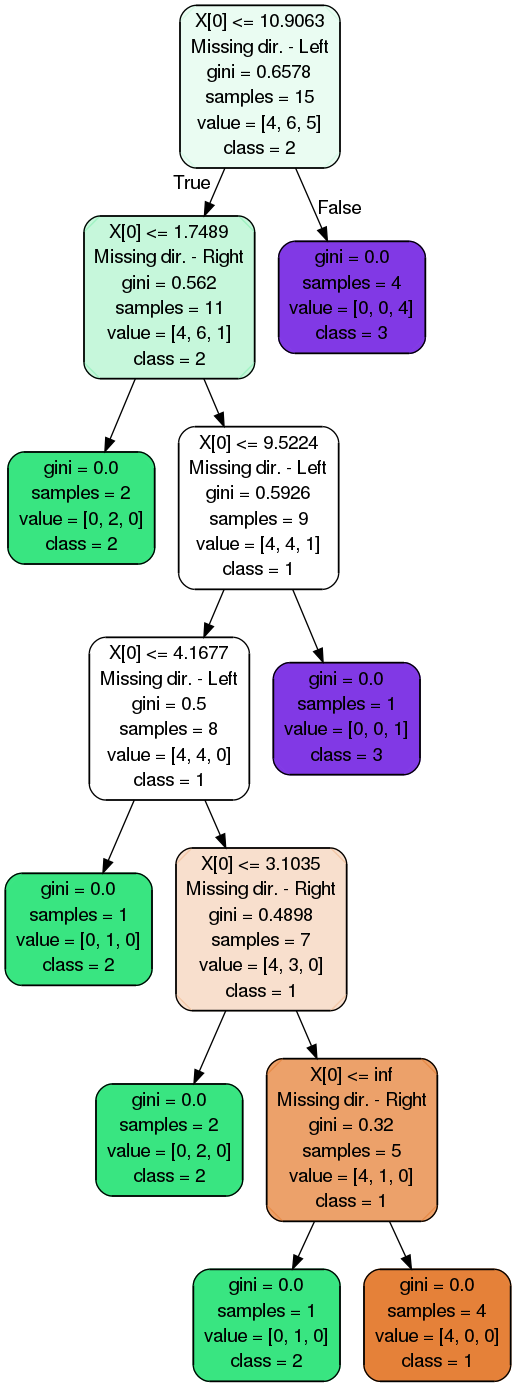

In [2]:
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import coo_matrix
import numpy as np
from get_graph import get_graph


from sklearn.tree import _tree, _splitter, _criterion
from sklearn.tree.tests import *
from sklearn.utils.testing import *
import matplotlib.pyplot as plt
import pygraphviz as pgv
import networkx as nx
import pygraphviz
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from value_dropper import drop_values

from sklearn.tree import *
from StringIO import StringIO
from io import BytesIO
import numpy as np
import six

# When the missing values are equally from all the classes
# the tree building should split it into separate node
# Using test cases as in the best splitter tests.
# Testing for actual thresholds or missing directions at each node does not
# Make sense. However in all of the corner cases the tree should capture
# the structure of the data exactly.

# All the missing values belong to a single class
rng = np.random.RandomState(42)
X_de = np.array([[np.nan], [np.nan], [np.nan], [np.nan],
                [0], [1], [2], [3], [4], [5],
                [10], [11], [12], [13], [15]])
X_sp = coo_matrix(X_de)
y = np.array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

# Test both the dense and sparse splitters
for X in (X_de, X_sp):
    dtc = DecisionTreeClassifier(missing_values="NaN",
                                 splitter="random",
                                 random_state=42).fit(X, y)
    # No nan thresholds (INF can be a threshold however)
    assert_false(np.any(np.isnan(dtc.tree_.threshold)))
    #assert_array_equal(dtc.predict(X), y)
    #print X
    
get_graph(dtc)

In [6]:
# The missing values and some available values in one class
X_de = np.array([[np.nan], [np.nan], [np.nan], [np.nan],
                 [0], [1], [2], [3], [4], [5]])
X_sp = coo_matrix(X_de)
y = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

for X in (X_de, X_sp):
    dtc = DecisionTreeClassifier(missing_values="NaN",
                                 splitter="random",
                                 random_state=42).fit(X, y)
    # No nan thresholds (INF can be a threshold however)
    assert_false(np.any(np.isnan(dtc.tree_.threshold)))
    assert_array_equal(dtc.predict(X), y)

I go here
0
7
0
(x nan _ nan _ nan _ nan _ )|(- )|( 0 _ )|(+ 1.00 _ 2.00 _ 3.00 _ 4.00 _ 10.00 _ 5.00 _ --- 11.00 _ 12.00 _ 13.00 _ 15.00 _ )
I go here
1
1
1
(x )|(- )|( 0 _ )|(+ --- 1.00 _ 2.00 _ )|(x nan _ nan _ nan _ nan _ )
I go here
0
2
0
(x nan _ nan _ nan _ nan _ )|(- )|( )|(+ 1.00 _ --- 2.00 _ )


AssertionError: 
Arrays are not equal

(mismatch 40.0%)
 x: array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3])
 y: array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [3]:
# The missing should be sent along with available to right child
y = np.array([2, 2, 2, 2, 1, 1, 1, 1, 2, 2])

for X in (X_de, X_sp):
    dtc = DecisionTreeClassifier(missing_values="NaN",
                                 splitter="random",
                                 random_state=42).fit(X, y)
    # No NAN or INF thresholds
    assert_all_finite(dtc.tree_.threshold)
    assert_array_equal(dtc.predict(X), y)

# When no missing exist, none of the thresholds should be NaN/Inf
# All the missing_direction should be MISSING_DIR_UNDEF
X_de = rng.random_sample((10, 2))
X_sp = coo_matrix(X_de)
y = rng.randint(0, 10, (10,))

for X in (X_de, X_sp):
    dtc = DecisionTreeClassifier(missing_values="NaN",
                                 splitter="random",
                                 random_state=42).fit(X, y)
    # No missing direction should be set
    assert_true(np.all(dtc.tree_.missing_direction == MISSING_DIR_UNDEF))
    assert_all_finite(dtc.tree_.threshold)
    assert_array_equal(dtc.predict(X), y)

# When the missing values are equally from all the classes
# the tree building should split it into separate node
X_de = np.array([[110], [100], [1], [2], [0], [np.nan], [500],
                [600], [np.nan], [5]])
X_sp = coo_matrix(X_de)
y = np.array([1, 1, 0, 0, 0, 0, 1, 1, 1, 0])

for X in (X_de, X_sp):
    dtc = DecisionTreeClassifier(missing_values="NaN",
                                 splitter="random",
                                 random_state=42).fit(X, y)

    # No nan thresholds (INF can be a threshold however)
    assert_false(np.any(np.isnan(dtc.tree_.threshold)))
    try:
        # This should not pass as both the missing values are grouped to
        # single class
        assert_array_equal(dtc.predict(X), y)
    except AssertionError:
        pass

I go here
0
7
0
(x nan _ nan _ nan _ nan _ )|(- )|( 0 _ )|(+ 1.00 _ 2.00 _ 3.00 _ 4.00 _ 10.00 _ 5.00 _ --- 11.00 _ 12.00 _ 13.00 _ 15.00 _ )
I go here
1
1
1
(x )|(- )|( 0 _ )|(+ --- 1.00 _ 2.00 _ )|(x nan _ nan _ nan _ nan _ )
I go here
0
2
0
(x nan _ nan _ nan _ nan _ )|(- )|( )|(+ 1.00 _ --- 2.00 _ )


AssertionError: 
Arrays are not equal

(mismatch 40.0%)
 x: array([1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3])
 y: array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [1]:
dtc = DecisionTreeClassifier(missing_values='NaN', random_state=42, splitter='best').fit(X_de, y)
get_graph(dtc)

NameError: name 'DecisionTreeClassifier' is not defined

In [1]:
plt.figure().set_size_inches((5, 5))
plt.axis('off')

mpimg.imread("_image.png")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


NameError: name 'plt' is not defined

SyntaxError: invalid syntax (<ipython-input-5-f1e1a2a235c4>, line 7)

In [6]:
X_de = np.array([[np.nan], [np.nan], [np.nan], [np.nan],
                 [0], [1], [2], [3], [4], [5]])
y = np.array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

NameError: name 'np' is not defined

In [6]:
print dtc.predict(X_de)
print y

[0 0 1 1 1 2 2 2 2 2]
[0 0 1 1 1 2 2 2 2 2]


In [2]:
from scipy.sparse import csc_matrix
import numpy as np

In [3]:
X = csc_matrix(np.array([[1, 2, 0, 4],
                         [2, 0, 1, 1],
                         [1, 0, 0, 0]]))

In [4]:
X.data

array([1, 2, 1, 2, 1, 4, 1])

In [5]:
X.indices

array([0, 1, 2, 0, 1, 0, 1], dtype=int32)

In [6]:
X.indptr

array([0, 3, 4, 5, 7], dtype=int32)

In [18]:
X = csr_matrix([0])

In [33]:
data = np.array([1, 2, 4, 2, 1, 1, 1])

In [34]:
indices = np.array([0, 1, 3, 0, 2, 3, 0])

In [35]:
indptr = np.array([0, 3, 6, 7])

In [36]:
X = csr_matrix((3, 4), dtype=np.int)

In [19]:
from sklearn.cluster import KMeans

from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(random_state=0)

km = KMeans(n_clusters=3, random_state=0).fit(X)

center_i = 2
print np.mean(X[km.labels_ == center_i], axis=0)
km.cluster_centers_[center_i]


[ 0.9801637   4.30837857]


array([ 0.9801637 ,  4.30837857])